## Import package

In [1]:
import torch
from torch import nn
import csv
import numpy as np
import emoji
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

## Device

In [2]:
device = "cuda" if torch.cuda.is_available else cpu

## Glove File:

In [3]:
def glove(glove_file):
    with open(glove_file, 'rb') as f:
        words = []
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            byte_string = curr_word
            curr_word = byte_string.decode('utf-8')
            words.append(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [4]:
glove_file = r"C:\Users\rahul\python\Machine learning\Data\glove.6B.50d.txt"
word_to_index, index_to_word, word_to_vec_map = glove(glove_file)

## Emoji Dictionary:

In [5]:
emoji_dictionary = {
    0:'❤️',
    1:'⚾',
    2:'😄',
    3:'😔',
    4:'🍴',
}

def label_to_emoji(label):
    return emoji_dictionary[label]

In [6]:
emoji_dictionary

{0: '❤️', 1: '⚾', 2: '😄', 3: '😔', 4: '🍴'}

## Important functions to extract features:

In [7]:
def sentence_to_index(array_word,word_to_index=word_to_index,max_len = 50):
    indices = torch.zeros(max_len)
    for idx,word in enumerate(array_word.lower().split()):
        if word in word_to_index and idx < max_len:
            indices[idx] = word_to_index[word]
    return indices.long()

def pretrained_embedded_layer(word_to_vec_map,word_to_index):
    
    num_embeddings = len(word_to_vec_map) +1
    embedding_dim = len(word_to_vec_map[list(word_to_vec_map.keys())[0]])
    
    embeddings = torch.zeros(num_embeddings,embedding_dim)
    
    for word,idx in word_to_index.items():
        embeddings[idx,:] = torch.from_numpy(word_to_vec_map[word])
        
    embedding_layer = nn.Embedding.from_pretrained(embeddings.to(device),freeze=True)
    
    return embedding_layer

In [8]:
from torch.utils.data import DataLoader,Dataset

class Custom_dataset(Dataset):
    def __init__(self,sample_dir):
        self.sample_dir = sample_dir
        self.df = pd.read_csv(sample_dir,names=["Sentence","label"],skiprows=1)
        #self.df.columns = ["Sentence","label"]
        self.df["len"] = self.df.Sentence.apply(self.len_check)
        self.max_len = max(self.df.len)
        
    def __len__(self):
        #print(self.df)
        return len(self.df)
    
    def len_check(self,x):
        return len(x.split())
    
    def __getitem__(self,index):
        sample = self.df.Sentence.iloc[index]
        label = self.df.label.iloc[index]
        sample = sentence_to_index(sample,word_to_index,self.max_len)
        return sample,label

## Model:

In [9]:
class Emojify__Rnn(nn.Module):
    def __init__(self,hidden_size,num_layers,bidirectional,word_to_vec_map=word_to_vec_map,word_to_index=word_to_index):
        super().__init__()
        if bidirectional:
            bi_value = 2
        else:
            bi_value = 1
        embedding_layer = pretrained_embedded_layer(word_to_vec_map,word_to_index)
        self.embedding_layer = embedding_layer
        self.packed_padded_seq = nn.utils.rnn.pack_padded_sequence
        self.pad_packed = nn.utils.rnn.pad_packed_sequence
        self.lstm1 = nn.LSTM(input_size=50,
                            hidden_size=hidden_size,
                            batch_first=True,
                            num_layers=num_layers,
                            bidirectional = bidirectional,
                            dropout=0.5)
        self.linear1 = nn.Linear(hidden_size,64)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(64,5)
        self.apply(self._init_weights)
        
    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)
        if isinstance(layer, nn.LSTM):
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0.01)
        
    
    def forward(self,X):
        lengths = torch.count_nonzero(X,dim=1).cpu()
        total_length = X.size(-1)
        X = self.embedding_layer(X)
        X = self.packed_padded_seq(input=X,lengths=lengths,batch_first=True,enforce_sorted=False)
        X,_ = self.lstm1(X)
        X,_ = self.pad_packed(X,batch_first=True,padding_value = 0,total_length = total_length )
        X = X[torch.arange(X.size(0)), lengths - 1, :]
        X = self.linear1(X)
        X = self.dropout(X)
        X = self.linear2(X)
        
        return X

In [10]:
model = Emojify__Rnn(128,2,False,word_to_vec_map,word_to_index).to(device)

## Sample dir :

In [11]:
train_sample_dir = r"C:\Users\rahul\python\Machine learning\Data\train_emoji.csv"
test_sample_dir = r"C:\Users\rahul\python\Machine learning\Data\test_emoji.csv" 

In [12]:
train_dataset = Custom_dataset(train_sample_dir)
train_dataLoader = DataLoader(dataset=train_dataset,batch_size=16,shuffle=False)

test_dataset = Custom_dataset(test_sample_dir)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=16,shuffle=False)

## Loss and optimizer :

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)

## Training and Testing:

In [14]:
def train_step(model,dataloader,loss_fn,optimizer,device):
    model.train()
    
    total_loss = 0
    total_acc = 0
    
    for sentence,label in (dataloader):
        sentence = sentence.to(device)
        label = label.to(device)
        
        # forward pass :
        logits = model(sentence)
        label_pred = nn.Softmax(dim=1)(logits)
        
        # loss & Accuracy :
        loss = loss_fn(logits,label)
        acc = (label_pred.argmax(dim=1) == label).sum().item()/(label.size(0))
        
        total_loss += loss
        total_acc += acc
        
        # optimizer zero grad:
        optimizer.zero_grad()
        
        # backward pass:
        loss.backward()
        
        # optimizer step:
        optimizer.step()
        
    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    
    return total_loss,total_acc

In [15]:
def test_step(model,dataloader,loss_fn,device):
    model.eval()
    
    total_loss = 0
    total_acc = 0
    
    for sentence,label in dataloader:
        sentence,label = sentence.to(device),label.to(device)
        
        # forward pass:
        logits = model(sentence)
        label_pred = nn.Softmax(dim=1)(logits)
        
        # loss & accuracy:
        loss = loss_fn(logits,label)
        acc = (label_pred.argmax(dim=1) == label).sum().item()/(label.size(0))
        
        total_loss += loss
        total_acc += acc
    
    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    
    return total_loss,total_acc

In [16]:
Epoch = 50
train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []
for epoch in tqdm(range(Epoch)):
    train_loss,train_acc = train_step(model,train_dataLoader,loss_fn,optimizer,device)
    train_loss_list.append(train_loss.item())
    train_acc_list.append(train_acc)
    test_loss,test_acc = test_step(model,test_dataloader,loss_fn,device)
    test_loss_list.append(test_loss.item())
    test_acc_list.append(test_acc)
    if epoch % 10 ==0:
        print(f"Epoch__ {epoch}")
        print(f"Train Loss: {train_loss:.2f} | Train Accuracy : {train_acc:.2f}")
        print(f"Validation Loss: {test_loss:.2f} | Validation Accuracy : {test_acc:.2f}")
        print() 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch__ 0
Train Loss: 1.56 | Train Accuracy : 0.32
Validation Loss: 1.49 | Validation Accuracy : 0.33

Epoch__ 10
Train Loss: 0.65 | Train Accuracy : 0.78
Validation Loss: 1.00 | Validation Accuracy : 0.54

Epoch__ 20
Train Loss: 0.37 | Train Accuracy : 0.88
Validation Loss: 0.89 | Validation Accuracy : 0.67

Epoch__ 30
Train Loss: 0.31 | Train Accuracy : 0.90
Validation Loss: 0.93 | Validation Accuracy : 0.72

Epoch__ 40
Train Loss: 0.21 | Train Accuracy : 0.95
Validation Loss: 1.03 | Validation Accuracy : 0.71



## Loss & Accuracy plot:

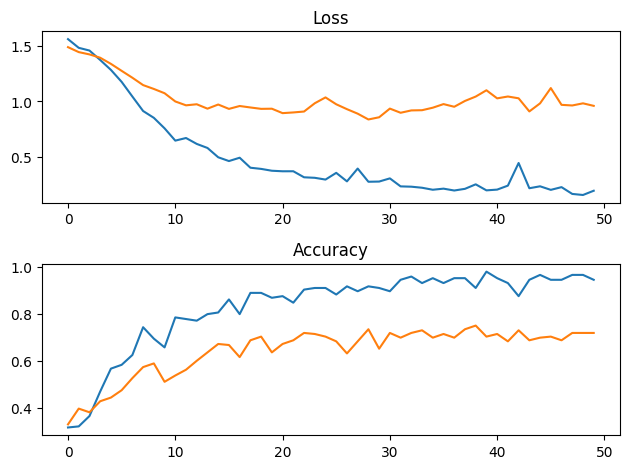

In [17]:
plt.subplot(2,1,1)
plt.title("Loss")
plt.plot(range(Epoch),train_loss_list,label = "Train loss")
plt.plot(range(Epoch),test_loss_list, label = "Validation loss")


plt.subplot(2,1,2)
plt.title("Accuracy")
plt.plot(range(Epoch),train_acc_list,label = "Train Accuracy")
plt.plot(range(Epoch),test_acc_list, label = "Validation Accuracy") 

plt.tight_layout()

lan = input()
X = sentence_to_index(lan,word_to_index,10)
logits = model(X.unsqueeze(0).to(device))
pred = torch.round(nn.Softmax(dim=1)(logits)).detach()
label_to_emoji(pred.argmax(dim=1).item())

In [18]:
test_df = pd.read_csv(test_sample_dir,names=["sentence","label"])
train_df = pd.read_csv(train_sample_dir,names=["sentence","label"])

In [19]:
def match_check(model,test_df,device,label_to_emoji=label_to_emoji):
    prediction = []
    for line in test_df.sentence:
        X = sentence_to_index(line,word_to_index,10)
        logits = model(X.unsqueeze(0).to(device))
        pred = torch.round(nn.Softmax(dim=1)(logits)).detach()
        prediction.append(pred.argmax(dim=1).item())
        label_to_emoji(pred.argmax(dim=1).item())

    actual_emoji =[]
    for label in test_df.label:
        actual_emoji.append(label_to_emoji(label))
    test_df["actual_emoji"] = actual_emoji

    prediction = np.array(prediction)
    test_df["prediction"] = prediction

    pred_emoji = []
    for pred in prediction:
        pred_emoji.append(label_to_emoji(pred))

    test_df["pred_emoji"] = pred_emoji

    return test_df[test_df.label != test_df.prediction][["sentence","actual_emoji","pred_emoji"]]

In [20]:
match_check(model,test_df,device)

,sentence,actual_emoji,pred_emoji
2,he got a raise\t,😄,❤️
7,We had such a lovely dinner tonight\t,❤️,😄
11,work is hard\t,😔,😄
12,This girl is messing with me\t,😔,❤️
13,are you serious ha ha\t,😄,😔
16,work is horrible\t,😔,😄
19,any suggestions for dinner\t,🍴,😄
21,you brighten my day\t,😄,❤️
26,I worked during my birthday\t,😔,😄
28,enjoy your break\t,😄,❤️
